In [1]:
# import libraries
from asyncio import sleep
from matipo import SEQUENCE_DIR, GLOBALS_DIR
from matipo.sequence import Sequence
from matipo.util.autophase import autophase
from matipo.util.decimation import decimate
from matipo.util.fft import fft_reconstruction
from matipo.util.etl import deinterlace
from pathlib import Path
import ipyvolume as ipv
from matplotlib import cm
import numpy as np
import matplotlib.pyplot as plt

# progress_handler for Sequence.run() that simply prints the progress
def print_progress(p, l):
    if (p*4)%l==0: # only print 4 times per run
        print(p, '/', l)

### 2D Flow Z velocity Profile Experiment

This experiment measures a 2D X/Y map of the Z component of the flow velocity.
The image is a projection so the velocity will be averaged over the Z axis.
A sample that is uniform in the Z direction like a simple tube is recommended.

Flow speed can be controlled with the Stepper Control dashboard app.
The final image may be incorrect due to phase wrapping if the flow speed is too fast.

Set a directory and experiment name for saving the data:

In [2]:
# set save directory and base file name
SAVE_DIR = '/home/data/flow-2D-RARE'
SAVE_NAME = 'test'

# make the save directory if it doesn't exist
Path(SAVE_DIR).mkdir(parents=True, exist_ok=True)

#### Running the experiment:
1. load the pulse sequence
2. load global variables (pulse calibration, frequency, shims)
3. set up 2D projection imaging parameters
4. set negative flow encode gradient and run the sequence, storing k-space data as `y_vzn`
5. set positive flow encode gradient and run the sequence, storing k-space data as `y_vzp`

In [39]:
# load local pulse sequence
seq = Sequence('flow-RARE.py')

# load relevant global variables
seq.loadpar(GLOBALS_DIR+'hardpulse_90.yaml')
seq.loadpar(GLOBALS_DIR+'hardpulse_180.yaml')
seq.loadpar(GLOBALS_DIR+'frequency.yaml')
seq.loadpar(GLOBALS_DIR+'shims.yaml')

DECIMATION = 4

G_CAL = 8.0e6 # Hz/m at max grad
G_FLOW = np.array((0, 0, 0.3))

seq.setpar(
    n_ETL=8,
    
    # phase encode Y axis
    n_phase_2=32,
    g_phase_2=(0, -0.5, 0),
    
    # frequency encode X axis
    t_dw=10e-6,
    n_samples=DECIMATION*32,
    g_read=(0.3, 0, 0),
    
    t_qfilter=400e-6,
    g_qfilter=(0.5, -0.5, 0.5),
    
    g_spoil=(0.8, 0, 0), # same direction as read gradient
    t_spoil=1000e-6,
    
    t_flow=1000e-6,
    t_flow_spacing=1200e-6,
    g_flow=(0,0,0),
    g_flow_tweak=(0.998,0.998,0.998),
    
    t_end=200e-3,
    n_scans=4
)

seq.setpar(t_phase=np.abs(np.linalg.norm(seq.par.g_read)/np.linalg.norm(seq.par.g_phase_2))*(seq.par.t_dw*seq.par.n_samples)/2)

# calculate VENC, the velocity that produces a pi phase shift
VENC = np.pi/(2*np.pi*G_CAL*2*np.linalg.norm(G_FLOW)*seq.par.t_flow*seq.par.t_flow_spacing)

# print out the parameter set for reference
print(seq.par)
print('Venc:', VENC)

# not perfectly accurate, but close enough
t_echo = seq.par.t_180 + 2*seq.par.t_phase + seq.par.t_dw*seq.par.n_samples
t_run = 2*seq.par.t_flow + seq.par.n_ETL*t_echo + seq.par.t_end
t_scan = ((seq.par.n_phase_2*seq.par.n_phase_1)//seq.par.n_ETL+1) * t_run
t_total = seq.par.n_scans*t_scan
print(f'total time (mins): {2*t_total/60:.1f}')

print('Acquiring image with negative flow encoding')
seq.setpar(g_flow=-G_FLOW)
await seq.run(progress_handler=print_progress)
y_vzn = decimate(
    deinterlace(seq.data, seq.par.n_ETL, 1, seq.par.n_phase_2, seq.par.n_samples), 
    DECIMATION, axis=1)
# save data and parameters
np.save(f'{SAVE_DIR}/{SAVE_NAME}_vzn', y_vzn)
seq.savepar(f'{SAVE_DIR}/{SAVE_NAME}_vzn.yaml')

print('Acquiring image with positive flow encoding')
seq.setpar(g_flow=G_FLOW)
await seq.run(progress_handler=print_progress)
y_vzp = decimate(
    deinterlace(seq.data, seq.par.n_ETL, 1, seq.par.n_phase_2, seq.par.n_samples), 
    DECIMATION, axis=1)
np.save(f'{SAVE_DIR}/{SAVE_NAME}_vzp', y_vzp)
seq.savepar(f'{SAVE_DIR}/{SAVE_NAME}_vzp.yaml')

ParameterSet(n_scans=4, f=15089003.710607288, a_90=0.34987021061682183, t_90=3.2e-05, a_180=0.7263180024450473, t_180=3.2e-05, t_dw=1e-05, n_samples=128, g_read=array([0.3, 0. , 0. ]), t_phase=0.000384, n_phase_1=1, g_phase_1=array([0., 0., 0.]), n_phase_2=32, g_phase_2=array([ 0. , -0.5,  0. ]), n_ETL=8, t_flow=0.001, t_flow_spacing=0.0012, g_flow=array([0., 0., 0.]), g_flow_tweak=array([0.998, 0.998, 0.998]), t_qfilter=0.0004, g_qfilter=array([ 0.5, -0.5,  0.5]), t_spoil=0.001, g_spoil=array([0.8, 0. , 0. ]), t_end=0.2, t_grad_ramp=0.0001, n_grad_ramp=10, shim_x=0.22946196224654097, shim_y=0.20694016858525605, shim_z=-0.5266442602004828, shim_z2=-0.18704360002659268, shim_zx=-0.6006874142351788, shim_zy=0.07567322769817048, shim_xy=0.015376149434010347, shim_x2y2=0.31943003296871364)
Venc: 0.08680555555555557
total time (mins): 0.1
Acquiring image with negative flow encoding
1 / 4
2 / 4
3 / 4
4 / 4
Acquiring image with positive flow encoding
1 / 4
2 / 4
3 / 4
4 / 4


#### Reconstruct the images from k-space data using fourier method:

In [40]:
# run FFT with some upscaling and windowing to get the images
im_vzn = fft_reconstruction(y_vzn, upscale_factor=2, gaussian_blur=1)
im_vzp = fft_reconstruction(y_vzp, upscale_factor=2, gaussian_blur=1)

#### Plot the images and a mask of regions with significant signal:

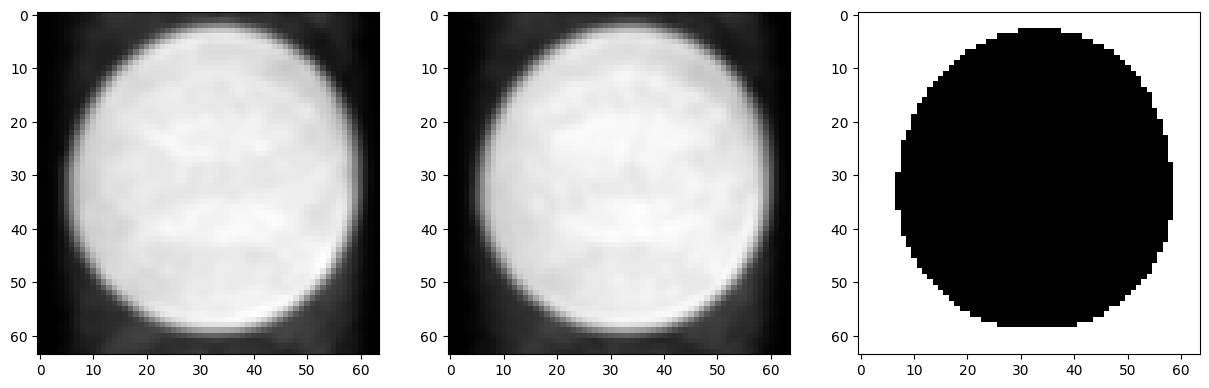

In [41]:
# make a filter array by thresholding the magnitude of the signal
# this can be used to exclude areas with no signal when plotting phase difference
filt = np.abs(im_vzn)*np.abs(im_vzp)
thresh = 1*np.mean(filt) # adjust to alter the threshold, quarter of maximum is a good starting point
filt[filt > thresh] = 1
filt[filt <= thresh] = np.nan

# plot the signal magnitudes of the two images and the resulting filter
cmap = 'gray'
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15,5))
axes[0].imshow(np.abs(im_vzn), cmap=cmap)
axes[1].imshow(np.abs(im_vzp), cmap=cmap)
axes[2].imshow(filt, cmap=cmap)
plt.show()

#### Plot the phase of the images
The flow encode gradients will introduce a phase shift proportional to the flow velocity in the direction of the gradient.
We can plot maps of the phase to see this phase shift directly.

Note: the phase may also vary across the image, but we are interested in the difference between the two images.

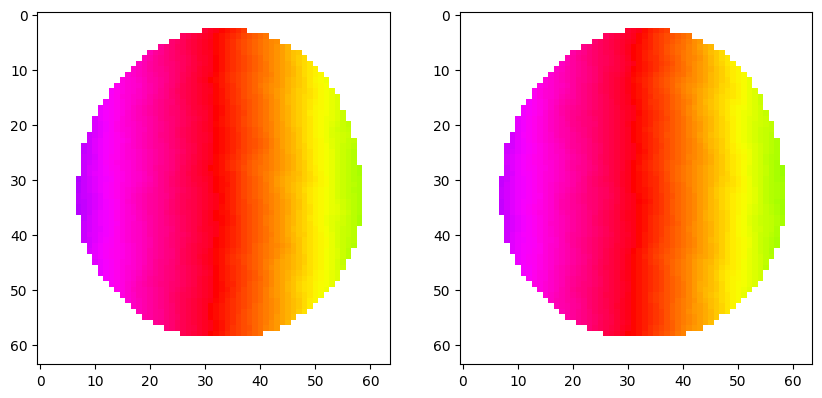

In [42]:
# plot the phase of the images
cmap='hsv' # cyclical colormap for phase plots
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,5))
axes[0].imshow(filt*np.angle(im_vzn), vmin=-np.pi, vmax=np.pi, cmap=cmap)
axes[1].imshow(filt*np.angle(im_vzp), vmin=-np.pi, vmax=np.pi, cmap=cmap)
plt.show()

#### Calculate the flow velocity map

In [43]:
# calculate velocity from phase difference (uncalibrated, arbitrary units)
vz = -(VENC/np.pi)*filt*np.angle(im_vzp/im_vzn) # dividing complex numbers will take the difference of their angles

# maximum velocity magnitude, used for plots
vz_mag_max = np.nanmax(np.sqrt(vz*vz))
print('maximum speed:', vz_mag_max, 'm/s')

maximum speed: 0.0024779703773703515 m/s


#### Plot flow velocity as a color coded image
Note: discontinuities in the flow velocity indicate that the flow speed is too fast, or flow encode gradient too strong, causing phase wrapping.

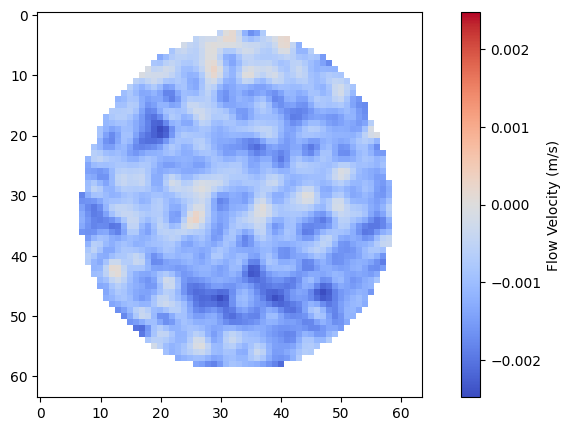

In [44]:
# plot velocity profile
plt.figure(figsize=(10,5), dpi=100)
plt.imshow(vz, cmap='coolwarm', vmin=-vz_mag_max, vmax=vz_mag_max)
# plt.contour(vz, cmap='coolwarm', vmin=-vz_mag_max, vmax=vz_mag_max)
plt.colorbar(label='Flow Velocity (m/s)')
plt.show()

#### Plot 1D Profiles along X and Y axes

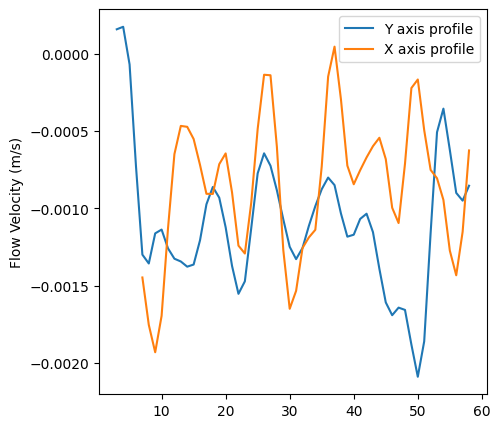

In [45]:
plt.figure(figsize=(5,5))
plt.plot(vz[:,vz.shape[1]//2], label='Y axis profile')
plt.plot(vz[vz.shape[0]//2,:], label='X axis profile')
plt.ylabel('Flow Velocity (m/s)')
plt.legend()
plt.show()

#### Plot flow velocity as a surface in 3D, where (X,Y) are spatial coords and Z is proportional to flow velocity

In [46]:
# plot velocity profile as a 3D heightmap
colormap = cm.coolwarm
Z = np.nan_to_num(vz)/VENC
znorm = Z - np.nanmin(Z)
znorm /= znorm.ptp()
color = colormap(znorm)
X, Y = np.meshgrid(range(Z.shape[0]),range(Z.shape[1]))
ipv.figure()
ipv.style.axes_off()
ipv.style.box_off()
ipv.plot_surface(X, Y, Z, color=color)
ipv.show()

Container(figure=Figure(box_center=[0.5, 0.5, 0.5], box_size=[1.0, 1.0, 1.0], camera=PerspectiveCamera(fov=45.…